**Import Libraries and Setup**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib


**Load Dataset** **and handle missing values**

In [2]:
dataset = pd.read_csv('/content/Harvest_Prediction_Factors_Merged.csv')

# Optionally, assign the dataset to df
df = dataset

# Handle missing values
df = df.dropna()



**Explore Dataset**

In [3]:
dataset.info()
dataset.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Rainfall (mm)            10000 non-null  float64
 1   Temperature (°C)         10000 non-null  float64
 2   Relative Humidity (%)    10000 non-null  float64
 3   Sunshine Hours (hrs)     10000 non-null  float64
 4   Wind Speed (km/h)        10000 non-null  float64
 5   Soil Type                10000 non-null  object 
 6   Irrigation Type          10000 non-null  object 
 7   Water Source             10000 non-null  object 
 8   Paddy Variety            10000 non-null  object 
 9   Fertilizer Usage (kg)    10000 non-null  float64
 10  Area (hectare)           10000 non-null  float64
 11  Soil Nitrogen (mg/kg)    10000 non-null  int64  
 12  Soil Phosphorus (mg/kg)  10000 non-null  int64  
 13  Soil Potassium (mg/kg)   10000 non-null  int64  
 14  Pest Severity          

,Rainfall (mm),Temperature (°C),Relative Humidity (%),Sunshine Hours (hrs),Wind Speed (km/h),Soil Type,Irrigation Type,Water Source,Paddy Variety,Fertilizer Usage (kg),Area (hectare),Soil Nitrogen (mg/kg),Soil Phosphorus (mg/kg),Soil Potassium (mg/kg),Pest Severity,Season,District,Yield (kg)
0,1407.3,32.2,60.2,9.1,11.3,Sandy,Rainfed,Well,BG 450,34.0,6.2,46,49,35,High,Maha,Polonnaruwa,38018.4
1,1412.7,30.7,66.0,7.0,10.9,Clay,Rainfed,Rainwater,BG 360,51.0,10.9,49,10,130,Medium,Yala,Jaffna,39752.3
2,1211.0,33.2,63.9,8.1,6.1,Loam,Tube Well,Well,BG 350,50.7,12.7,74,40,123,High,Maha,Batticaloa,38912.8
3,940.3,30.4,86.9,8.7,14.8,Loam,Rainfed,Well,BG 450,71.0,10.9,13,8,88,High,Yala,Batticaloa,38041.0
4,899.8,32.5,86.5,11.0,14.5,Loam,Rainfed,Well,BG 450,69.9,8.9,53,28,175,Medium,Maha,Polonnaruwa,39035.4


**Rows and Columns**

In [4]:
# Step 4: Check the Dimensions of the Dataset
rows, columns = dataset.shape
print(f"The dataset contains {rows} rows and {columns} columns.")


The dataset contains 10000 rows and 18 columns.


**Define Features and Target**

In [5]:
X = dataset.drop(columns=[' Yield (kg)'])
y = dataset[' Yield (kg)']


**Split Dataset into Training and Testing Sets**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Display training and testing sizes
print(f"Training data size: {X_train.shape}")
print(f"Testing data size: {X_test.shape}")


Training data size: (8000, 17)
Testing data size: (2000, 17)


**Separate numerical and categorical features**

In [7]:
# Separate numerical and categorical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)


Numerical Features: ['Rainfall (mm)', 'Temperature (°C)', 'Relative Humidity (%)', 'Sunshine Hours (hrs)', 'Wind Speed (km/h)', 'Fertilizer Usage (kg)', 'Area (hectare)', 'Soil Nitrogen (mg/kg)', 'Soil Phosphorus (mg/kg)', 'Soil Potassium (mg/kg)', ' Yield (kg)']
Categorical Features: ['Soil Type', 'Irrigation Type', 'Water Source', 'Paddy Variety', 'Pest Severity', 'Season', 'District']


**Correlation Heatmap for Numerical + Encoded Categorical Features**

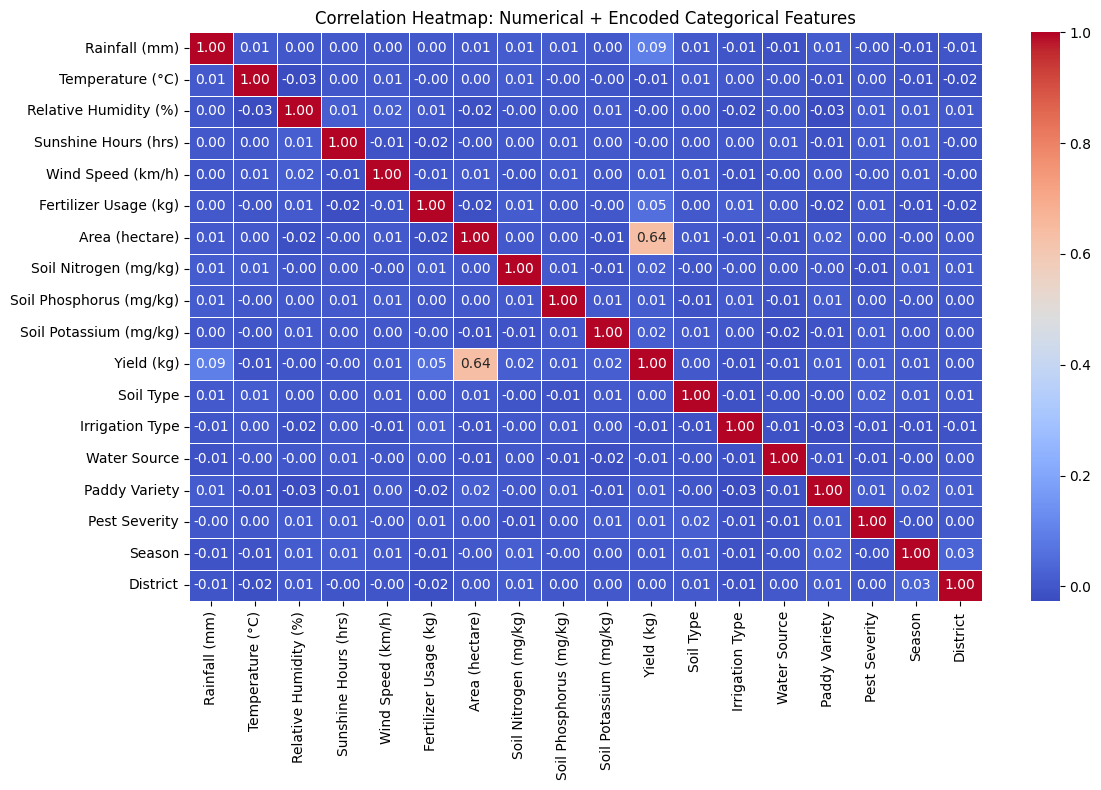

In [8]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


# Make a copy of the dataframe to encode
df_encoded = df.copy()

# Encode all categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

# Combine numerical and encoded categorical features
all_features = numerical_features + categorical_features

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded[all_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap: Numerical + Encoded Categorical Features')
plt.tight_layout()
plt.show()



**Preprocessing and Feature Transformation**



In [12]:
categorical_features = ['Soil Type', 'Irrigation Type', 'Water Source',
                        'Paddy Variety', 'Pest Severity', 'Season', 'District']

numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
print("numerical_features", numerical_features)

numerical_features = [col for col in numerical_features if col not in categorical_features]
print("numerical_features =", numerical_features)

# Preprocessing: Encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough',  # Leave numerical features untouched
    force_int_remainder_cols=False  # Future-proof behavior
)

print("\nPreprocessor Details:")
print(preprocessor)


numerical_features ['Rainfall (mm)', 'Temperature (°C)', 'Relative Humidity (%)', 'Sunshine Hours (hrs)', 'Wind Speed (km/h)', 'Fertilizer Usage (kg)', 'Area (hectare)', 'Soil Nitrogen (mg/kg)', 'Soil Phosphorus (mg/kg)', 'Soil Potassium (mg/kg)']
numerical_features = ['Rainfall (mm)', 'Temperature (°C)', 'Relative Humidity (%)', 'Sunshine Hours (hrs)', 'Wind Speed (km/h)', 'Fertilizer Usage (kg)', 'Area (hectare)', 'Soil Nitrogen (mg/kg)', 'Soil Phosphorus (mg/kg)', 'Soil Potassium (mg/kg)']

Preprocessor Details:
ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                  transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['Soil Type', 'Irrigation Type',
                                  'Water Source', 'Paddy Variety',
                                  'Pest Severity', 'Season', 'District'])])


**Create Pipeline for Preprocessing and Model**


In [10]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Data preprocessing step (scaling, encoding, etc.)

    ('model', RandomForestRegressor(
        n_estimators=150,              # Number of trees in the forest (reduces variance and prevents overfitting by averaging predictions)
        max_depth=18,                  # Limits the depth of each tree to prevent overfitting by controlling model complexity
        min_samples_split=10,          # Requires at least 10 samples to split a node (prevents overly specific splits)
        min_samples_leaf=4,            # Ensures that each leaf node has at least 4 samples, preventing overfitting to small data variations
        random_state=42                # Ensures reproducibility of results (ensures the same splits each time for consistency in testing)
    ))
])


**Train the Model**

In [11]:
pipeline.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Soil Type',
                                                   'Irrigation Type',
                                                   'Water Source',
                                                   'Paddy Variety',
                                                   'Pest Severity', 'Season',
                                                   'District'])])),
                ('model',
                 RandomForestRegressor(max_depth=18, min_samples_leaf=4,
                                       min_samples_split=10, n_estimators=150,
                                       random_state=42))])

**Training and Test Performance**

In [13]:
# Evaluate model performance on training and test sets
train_accuracy = r2_score(y_train, pipeline.predict(X_train))
test_accuracy = r2_score(y_test, pipeline.predict(X_test))

# Print accuracy results
print(f'\nTraining R² Score: {train_accuracy:.4f}')
print(f'Test R² Score: {test_accuracy:.4f}')



Training R² Score: 0.9901
Test R² Score: 0.9731


**Evaluation matrices of the model**

In [14]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict using the trained model
y_pred = pipeline.predict(X_test)

# Example metric calculations
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mse)

# Print the metrics
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

# MAPE and Accuracy
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracy = 100 - mape
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Regression Accuracy: {accuracy:.2f}%")


MAE: 510.0285261251583
MSE: 4755389.907179633
RMSE: 2180.685650702465
R-squared: 0.9730830528786836
Mean Absolute Percentage Error (MAPE): 3.49%
Regression Accuracy: 96.51%


**Save the test data**

In [15]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the dataset
file_path = '/content/Harvest_Prediction_Factors_Merged.csv'  # Update with your file path
data = pd.read_csv(file_path)

# Split the data into 80% training and 20% testing
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Save the test data to a CSV file
test_file_path = '/content/Harvest_Prediction_Test_Data.csv'  # Update with desired save location
test_data.to_csv(test_file_path, index=False)

print(f"Test data saved to: {test_file_path}")


Test data saved to: /content/Harvest_Prediction_Test_Data.csv


**Save the model**

In [16]:

# Save the model
model_path = "rice_yield_random_forest_model.pkl"
joblib.dump(pipeline, model_path)
print(f"Model saved to {model_path}")


Model saved to rice_yield_random_forest_model.pkl


**Permutation Feature Importance**

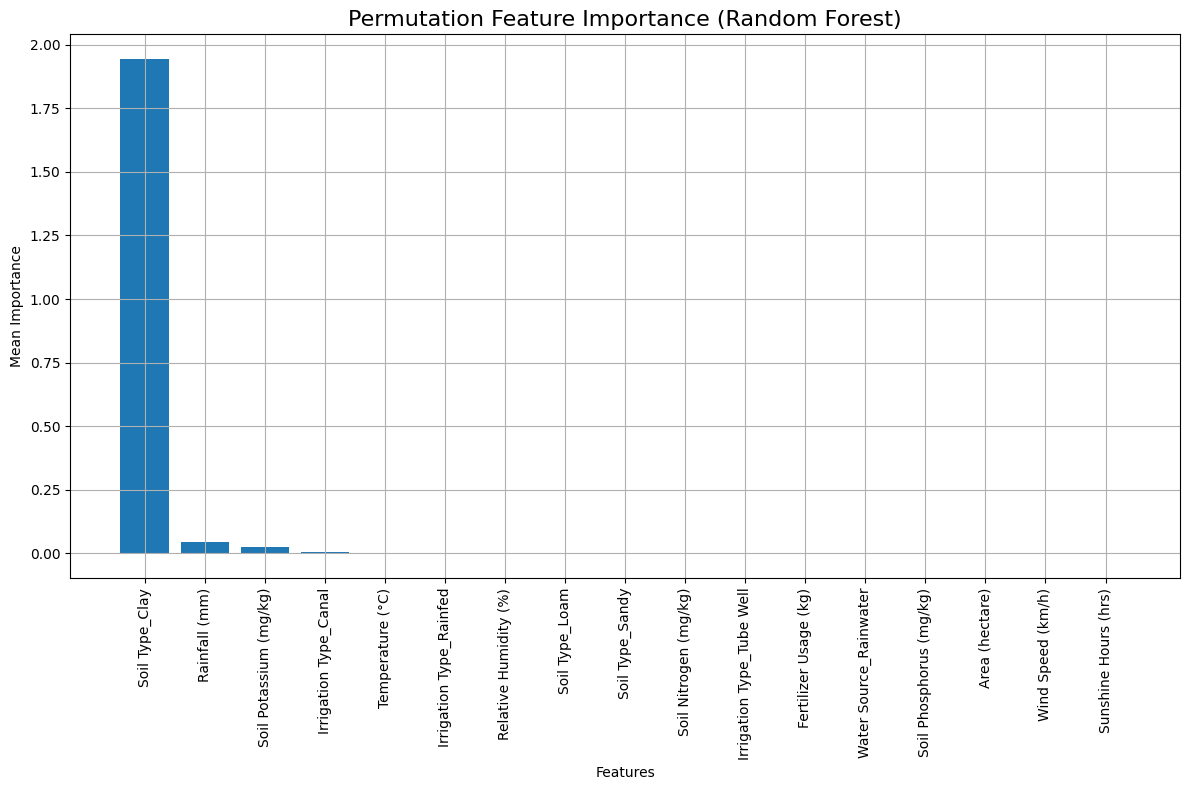

In [17]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Permutation importance
result = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42, scoring='r2')

# Get feature names
categorical_feature_names = pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, categorical_feature_names])

# Sort and plot
sorted_idx = result.importances_mean.argsort()[::-1]

plt.figure(figsize=(12, 8))
plt.bar(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
plt.xticks(range(len(sorted_idx)), all_feature_names[sorted_idx], rotation=90)
plt.title("Permutation Feature Importance (Random Forest)", fontsize=16)
plt.xlabel("Features")
plt.ylabel("Mean Importance")
plt.tight_layout()
plt.grid(True)
plt.show()

**Test data Performance**

Mean Squared Error (MSE): 4755389.907179633
Mean Absolute Error (MAE): 510.0285261251583


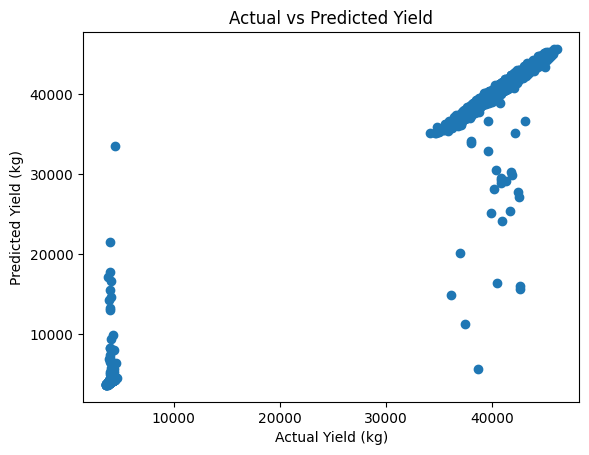

In [18]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the test data
test_file_path = '/content/Harvest_Prediction_Test_Data.csv'  # Update with your test data path
test_data = pd.read_csv(test_file_path)

# Separate features and target variable
X_test = test_data.drop(columns=[' Yield (kg)'])  # Replace 'Yield (kg)' with your target column name
y_test = test_data[' Yield (kg)']  # Replace 'Yield (kg)' with your target column name

# Load your trained model (ensure the model is trained and saved)
import joblib
model = joblib.load('rice_yield_random_forest_model.pkl')  # Update with your model path

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

# Optionally, visualize the results
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Yield (kg)")
plt.ylabel("Predicted Yield (kg)")
plt.title("Actual vs Predicted Yield")
plt.show()


**Comparison of Predicted and Test data**

In [ ]:
import pandas as pd

# Function to predict harvest based on input test data
def predict_test_data(model, test_data):
    # Prepare to store results
    results = []

    # Iterate through test data rows
    for index, row in test_data.iterrows():
        # Extract input features
        new_data = pd.DataFrame([{
            'Rainfall (mm)': row['Rainfall (mm)'],
            'Temperature (°C)': row['Temperature (°C)'],
            'Relative Humidity (%)': row['Relative Humidity (%)'],
            'Sunshine Hours (hrs)': row['Sunshine Hours (hrs)'],
            'Wind Speed (km/h)': row['Wind Speed (km/h)'],
            'Soil Type': row['Soil Type'],
            'Irrigation Type': row['Irrigation Type'],
            'Water Source': row['Water Source'],
            'Paddy Variety': row['Paddy Variety'],
            'Fertilizer Usage (kg)': row['Fertilizer Usage (kg)'],
            'Area (hectare)': row['Area (hectare)'],
            'Soil Nitrogen (mg/kg)': row['Soil Nitrogen (mg/kg)'],
            'Soil Phosphorus (mg/kg)': row['Soil Phosphorus (mg/kg)'],
            'Soil Potassium (mg/kg)': row['Soil Potassium (mg/kg)'],
            'Pest Severity': row['Pest Severity'],
            'Season': row['Season'],
            'District': row['District']
        }])

        # Predict the total yield
        predicted_yield = model.predict(new_data)[0]

        # Store actual and predicted values
        results.append({
            "Actual Yield": row[' Yield (kg)'],
            "Predicted Yield": predicted_yield
        })

    # Return results as a DataFrame
    return pd.DataFrame(results)

# Load the test data
test_file_path = '/content/Harvest_Prediction_Test_Data.csv'  # Update with your file path
test_data = pd.read_csv(test_file_path)

# Load your trained model
import joblib
pipeline = joblib.load('rice_yield_random_forest_model.pkl')  # Update with your model path

# Predict for test data and compare
results_df = predict_test_data(pipeline, test_data)

# Save the results for evaluation
results_df.to_csv('/content/Prediction_Results.csv', index=False)

print("Prediction results saved to '/content/Prediction_Results.csv'")


Prediction results saved to '/content/Prediction_Results.csv'


**Farmer input data predict harvest based on land size**


In [ ]:
import pandas as pd

# Function to predict harvest based on input acreage and other factors, including recommendations based on yield comparison
def predict_total_harvest():
    # Step 1: Farmer inputs various factors
    print("=== Enter Farm Data ===")

    district = input("Enter the district: ")
    season = input("Enter the season (e.g., Maha, Yala): ")
    area = float(input("Enter the total area of land in hectares: "))
    rainfall = float(input("Enter the total rainfall in mm: "))
    temperature = float(input("Enter the temperature in °C: "))
    humidity = float(input("Enter the relative humidity percentage: "))
    sunshine_hours = float(input("Enter the total sunshine hours per day: "))
    wind_speed = float(input("Enter the average wind speed in km/h: "))
    soil_type = input("Enter the soil type (e.g., Loam, Sandy, Clay): ")
    irrigation_type = input("Enter the irrigation type (e.g., Rainfed, Canal, Tube Well): ")
    water_source = input("Enter the water source (e.g., Well, River, Rainwater): ")
    paddy_variety = input("Enter the paddy variety (e.g., BG 450, BG 250 , BG 350 , BG 360 ): ")
    fertilizer_usage = float(input("Enter the fertilizer usage in kg: "))
    soil_nitrogen = float(input("Enter the soil nitrogen level in mg/kg: "))
    soil_phosphorus = float(input("Enter the soil phosphorus level in mg/kg: "))
    soil_potassium = float(input("Enter the soil potassium level in mg/kg: "))
    pest_severity = input("Enter the pest severity (e.g., Low, Medium, High): ")


    # Step 2: Input for previous yield per acre
    previous_yield_per_hectare = float(input("Enter the previous yield per hectare in kg: "))

    # Step 3: Prepare the data for prediction
    new_data = pd.DataFrame([{
        'Rainfall (mm)': rainfall,
        'Temperature (°C)': temperature,
        'Relative Humidity (%)': humidity,
        'Sunshine Hours (hrs)': sunshine_hours,
        'Wind Speed (km/h)': wind_speed,
        'Soil Type': soil_type,
        'Irrigation Type': irrigation_type,
        'Water Source': water_source,
        'Paddy Variety': paddy_variety,
        'Fertilizer Usage (kg)': fertilizer_usage,
        'Area (hectare)': area,  # This is still used, but model predicts per acre
        'Soil Nitrogen (mg/kg)': soil_nitrogen,
        'Soil Phosphorus (mg/kg)': soil_phosphorus,
        'Soil Potassium (mg/kg)': soil_potassium,
        'Pest Severity': pest_severity,
        'Season': season,
        'District': district
    }])

    # Step 4: Predict the total yield using the trained model (replace `pipeline` with your actual model)
    Total_predicted_yield = pipeline.predict(new_data)[0]

    # Step 5: Calculate yield per acre (Optional, as yield prediction might already be per acre)
    predicted_yield_per_hectare = Total_predicted_yield / area

    # Step 6: Display the predicted results
    print(f"\n=== Predicted Results ===")
    print(f"Total Harvest for {area} hectare: {Total_predicted_yield:.2f} kg")
    print(f"Predicted Yield per hectare: {predicted_yield_per_hectare:.2f} kg")
    print("=========================")

    # Step 7: Compare the previous yield with the predicted yield and provide recommendations
    print("\n=== Recommendations Based on Yield Comparison ===")

    if previous_yield_per_hectare > predicted_yield_per_hectare:
        print("Condition: Previous Yield > Predicted Yield")
        print("\nPredicted Yield is LOWER than the Previous Yield.")
        print("Suggested Actions to Improve Yield:")
        print("- Optimize fertilizer usage based on soil tests.")
        print("- Improve irrigation practices to ensure consistent water supply.")
        print("- Consider pest control measures to minimize yield loss.")
        print("- Use high-yield paddy varieties suitable for the district.")
        print("- Apply balanced soil nutrients and organic matter.")

    elif predicted_yield_per_hectare > previous_yield_per_hectare:
        print("Condition: Predicted Yield > Previous Yield")
        print("\nPredicted Yield is HIGHER than the Previous Yield.")
        print("Recommendations for Maintaining or Further Improving Yield:")
        print("- Continue current agricultural practices.")
        print("- Monitor soil health regularly and apply nutrients accordingly.")
        print("- Use precision farming tools to track crop progress.")
        print("- Plan for seasonal crop rotation to maintain soil fertility.")
        print("- Use modern harvesting techniques to minimize post-harvest losses.")

    else:
        print("Condition: Previous Yield == Predicted Yield")
        print("\nPredicted Yield matches the Previous Yield. Keep up the current practices!")

    print("===========================")
    return Total_predicted_yield, predicted_yield_per_hectare

# Run the function
predict_total_harvest()


=== Enter Farm Data ===
Enter the district: Ampara
Enter the season (e.g., Maha, Yala): Maha
Enter the total area of land in hectares: 10
Enter the total rainfall in mm: 1200
Enter the temperature in °C: 24
Enter the relative humidity percentage: 12
Enter the total sunshine hours per day: 10
Enter the average wind speed in km/h: 10
Enter the soil type (e.g., Loam, Sandy, Clay): Loam
Enter the irrigation type (e.g., Rainfed, Canal, Tube Well): Canal
Enter the water source (e.g., Well, River, Rainwater): River
Enter the paddy variety (e.g., BG 450, BG 250 , BG 350 , BG 360 ): BG 450
Enter the fertilizer usage in kg: 1200
Enter the soil nitrogen level in mg/kg: 14
Enter the soil phosphorus level in mg/kg: 10
Enter the soil potassium level in mg/kg: 18
Enter the pest severity (e.g., Low, Medium, High): High
Enter the previous yield per hectare in kg: 1200

=== Predicted Results ===
Total Harvest for 10.0 hectare: 40598.82 kg
Predicted Yield per hectare: 4059.88 kg

=== Recommendations Base

(np.float64(40598.81875447606), np.float64(4059.881875447606))

**Visualize Model Performance**

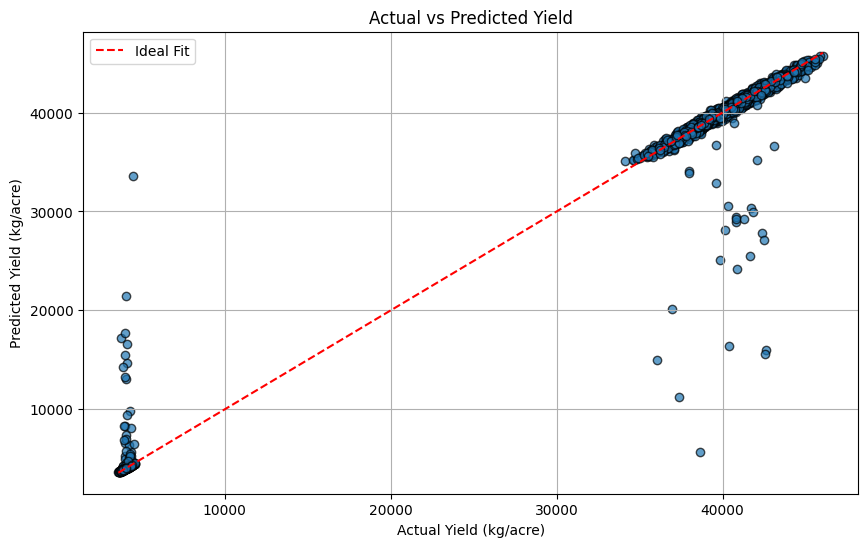

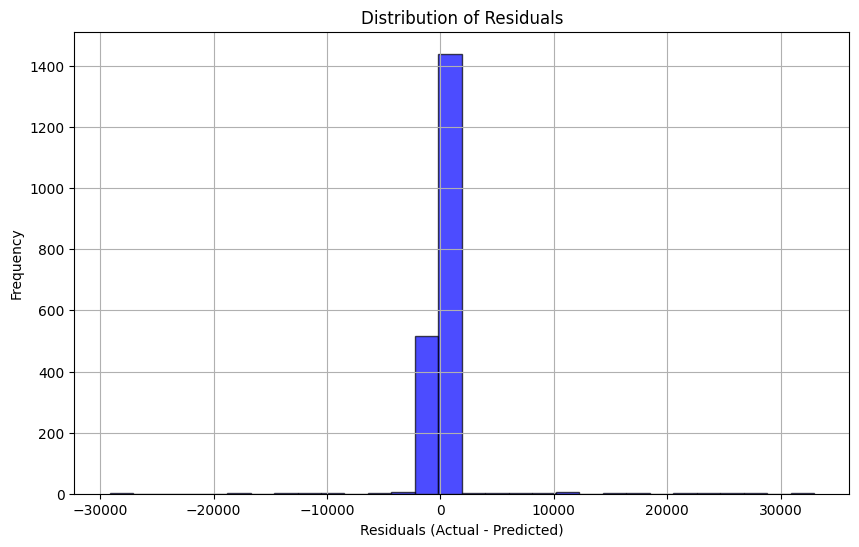

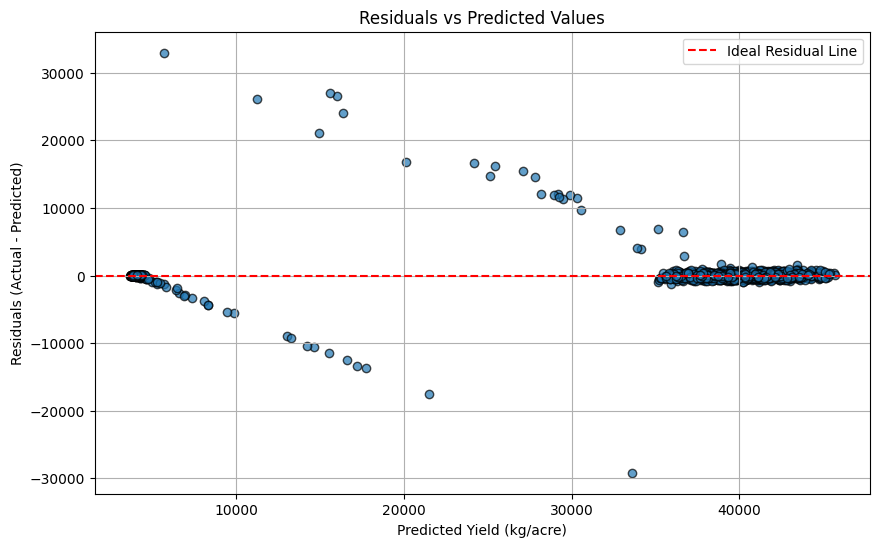

In [ ]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - y_pred

# Scatter plot of Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Ideal Fit")
plt.title("Actual vs Predicted Yield")
plt.xlabel("Actual Yield (kg/acre)")
plt.ylabel("Predicted Yield (kg/acre)")
plt.legend()
plt.grid(True)
plt.show()

# Histogram of Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', alpha=0.7, edgecolor='k')
plt.title("Distribution of Residuals")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Residuals vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7, edgecolor='k')
plt.axhline(0, color='red', linestyle='--', label="Ideal Residual Line")
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Yield (kg/acre)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.legend()
plt.grid(True)
plt.show()
